## Setup Data
- Link dataset: https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species
- Read the README.md file that contains all the information about the project. 


(torch,
numpy,
pandas,
opencv-python,
matplotlib,
seaborn,
scikit-learn)

#### Import the libraries used

In [1]:
# General use
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier


# SVM-related libraries
from utils import SVM_hyperparameter_tuning
from utils import PCA_KNN


# KNN-related libraries
import math

from itertools import product
from sklearn.neighbors import KNeighborsClassifier
from utils import KNN_hyperparameter_tuning


# PCA-related libraries
import random

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA


# VGG extractor feature
import torch
import argparse

import torchvision.models as models

from torchvision import transforms
from torchvision.models import VGG16_Weights


## Data organization

File *"butterflies and moths.csv"* contains 4 columns:
- **class id**: numerical class of the butterfly,
- **filepaths**: path to the individual image,
- **labels**: name of the category,
- **data set**: indicates whether the i-th butterfly is for train, valid or test.

Here I load the dataset and split the data into train, valid and test sets.

In [2]:
#~ [Load dataset]
file_path = 'butterflies and moths.csv'
df = pd.read_csv(file_path)
print('Entire dataset: \n', df)

#~ [Data division into train, valid and test sets]
# For each df_* there are the: 
# - class id
# - filepaths
# - labels
# - data set
df_train = df[df['data set'] == 'train']
df_valid = df[df['data set'] == 'valid']
df_test = df[df['data set'] == 'test']


limit = 2
#~ [Different types of butterflies and moths are collected]
b_m_types = df_train['labels'].unique()
b_m_types = b_m_types[0:limit]
print('\n\nLabels: ', b_m_types)

#~ [The different id classes of butterflies and moths are collected]
b_m_class = df_train['class id'].unique()
b_m_class = b_m_class[0:limit]
print('\n\nClass id: ', b_m_class)

#~ [Consider only species indicated by the limit]
df_train = df_train[df_train["labels"].isin(b_m_types[0:limit])]
df_test = df_test[df_test["labels"].isin(b_m_types[0:limit])]
df_valid = df_valid[df_valid["labels"].isin(b_m_types[0:limit])]

# Join all dataframe
df_new = pd.concat([df_train, df_test, df_valid])

Entire dataset: 
        class id                    filepaths           labels data set
0             0         train/ADONIS/001.jpg           ADONIS    train
1             0         train/ADONIS/002.jpg           ADONIS    train
2             0         train/ADONIS/003.jpg           ADONIS    train
3             0         train/ADONIS/004.jpg           ADONIS    train
4             0         train/ADONIS/005.jpg           ADONIS    train
...         ...                          ...              ...      ...
13589        99  valid/ZEBRA LONG WING/1.jpg  ZEBRA LONG WING    valid
13590        99  valid/ZEBRA LONG WING/2.jpg  ZEBRA LONG WING    valid
13591        99  valid/ZEBRA LONG WING/3.jpg  ZEBRA LONG WING    valid
13592        99  valid/ZEBRA LONG WING/4.jpg  ZEBRA LONG WING    valid
13593        99  valid/ZEBRA LONG WING/5.jpg  ZEBRA LONG WING    valid

[13594 rows x 4 columns]


Labels:  ['ADONIS' 'AFRICAN GIANT SWALLOWTAIL']


Class id:  [0 1]


#### Analysis of the data at hand

- Figure 1: shows the number of butterflies in the dataset divided by category

- Figure 2: shows the amount of butterflies for train, test and valid sets

labels
ADONIS                       126
AFRICAN GIANT SWALLOWTAIL    107
Name: count, dtype: int64


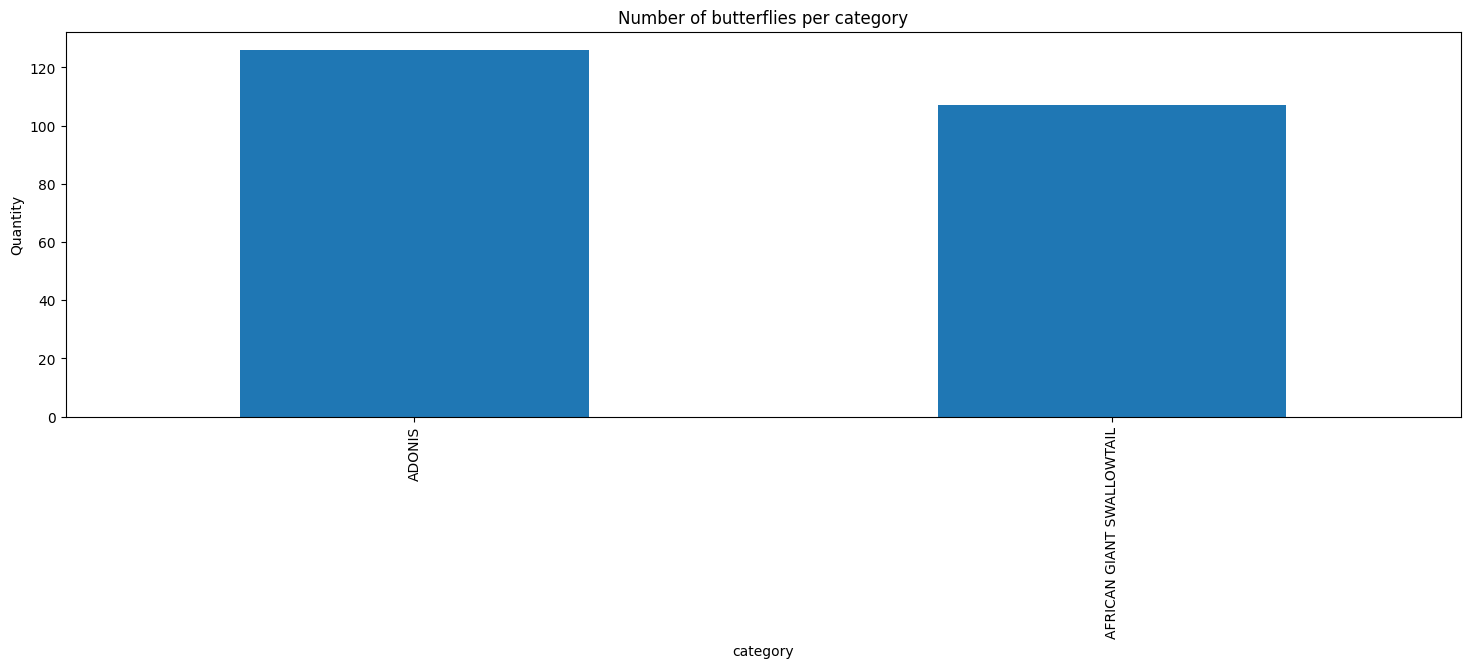

data set
train    233
test      10
valid     10
Name: count, dtype: int64


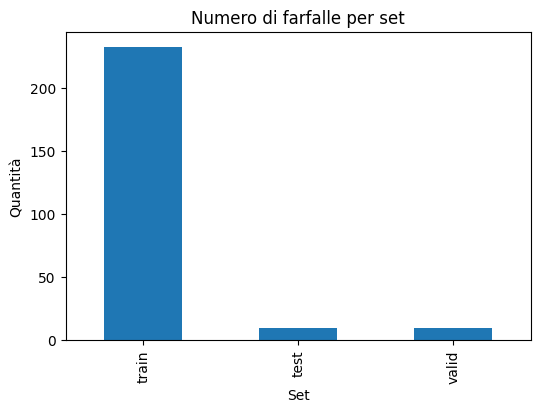

In [3]:
#~ [Calculate the number of butterflies for each category]
counts = df_train['labels'].value_counts()
print(counts)

#~ [Plot the bar graph]
plt.figure(figsize=(18,5))
counts.plot(kind='bar')
plt.title('Number of butterflies per category')
plt.xlabel('category')
plt.ylabel('Quantity')
plt.show()


#~ [Calculate the number of butterflies for each set (train, valid, test)]
counts = df_train['data set'].value_counts()
counts = pd.concat([counts, df_test['data set'].value_counts()])
counts = pd.concat([counts, df_valid['data set'].value_counts()])
print(counts)

#~ [Plot the bar graph]
plt.figure(figsize=(6,4))
counts.plot(kind='bar')
plt.title('Numero di farfalle per set')
plt.xlabel('Set')
plt.ylabel('Quantità')
plt.show()

#### Data preprocessing

- Our _labels_ correspond to butterfly species (labels column)
- Our _data_ match the butterfly images
  - Images are handled in both color and black/white 
  - Images are resized to 50x50

In [4]:
#~ [A dictionary is created for species]
# b_m_types -> species name 
# b_m_class -> species class_id
species_dict = {}
for idx, i in enumerate(b_m_types[0:limit]): 
    species_dict[i] = idx

prime_dieci_chiavi = list(species_dict.keys())[:limit]                               # Get the first limit keys 
list_species = {chiave: species_dict[chiave] for chiave in prime_dieci_chiavi}       # Create new dictionary with matching keys and values

#~ [Dictionary of Images]
# Color images
img_dict_x = {
    'train': [],
    'test': [],
    'valid': []
}
img_dict_y = {
    'train': [],
    'test': [],
    'valid': []
}

# B/W images
img_dict_bn_x = {
    'train': [],
    'test': [],
    'valid': []
}
img_dict_bn_y = {
    'train': [],
    'test': [],
    'valid': []
}

# Images with HSV
img_hsv_hist_x = {
    'train': [],
    'test': [],
    'valid': []
}
img_hsv_hist_y = {
    'train': [],
    'test': [],
    'valid': []
}


images = []                             # List of colored images
images_grey = []                        # List of black/white images
images_hsv_histo = []                   # List of HSV histograms relating to images


for i, row in df_new.iterrows():
    filepath = row['filepaths']
    class_id = row['class id']
    index = row['data set']

    img = Image.open(filepath)          # Load the image from the path
    img = img.resize((50,50))           # Resize the image

    # Black/White
    img_grey = img.convert("L")                                 # Take image and convert it to grayscale
    img_dict_bn_x[index].append(np.array(img_grey).flatten())   # Take converted image and transform it into an np-array, with flatten for it to be one-dimensional
    img_dict_bn_y[index].append(class_id)                       # Take the class and add it to the index
    images_grey.append(np.array(img_grey).flatten())            # Add to the images_grey vector the img_grey    
    
    # Colored
    img_array = np.array(img)                                   # The colored image is converted to a numpy array
    img_dict_x[index].append(img_array) 
    img_dict_y[index].append(class_id)
    images.append(img_array)                                   

    # HSV histograms
    img = cv2.imread(filepath)                                 # Read images with cv2 to later analyze HSV histograms with cv2
    img = cv2.resize(img, (50,50))                             # Resize the images
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)             # Converts the image to HSV color space
    h, s, v = cv2.split(hsv_img)                               # Split the image into the separate channels
    
    hist_h = cv2.calcHist([h], [0], None, [256], [0, 256]).flatten()     # Calculate the histogram for each channel
    hist_s = cv2.calcHist([s], [0], None, [256], [0, 256]).flatten()
    hist_v = cv2.calcHist([v], [0], None, [256], [0, 256]).flatten()
    
    histo = np.concatenate((hist_h, hist_s, hist_v))           # Concatenates histograms into a single feature vector
    img_hsv_hist_x[index].append(histo)
    img_hsv_hist_y[index].append(class_id)
    images_hsv_histo.append(histo)      
    
    
#~ [Create numpy lists for the obtained lists]
images_np = np.array(images)
images_gray_np = np.array(images_grey)
images_hsv_histo_np = np.array(images_hsv_histo)

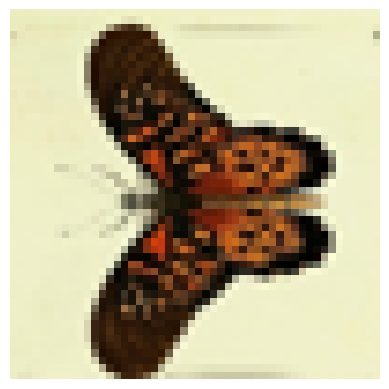

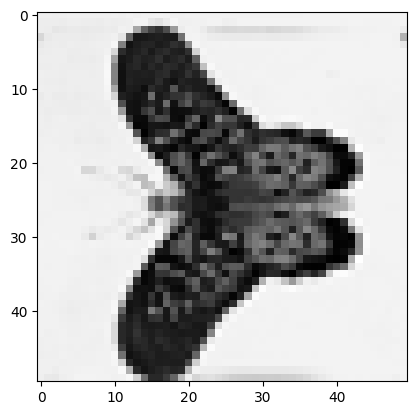

In [5]:
# This section show a random image
idx = random.randint(0, len(images)-1)    
for img in images[idx:idx+1]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

for img in images_grey[idx:idx+1]:
    img = img.reshape(50,50)
    plt.imshow(img, cmap='gray')
    plt.show()

#### Creation of train and test sets related to black/white images

- In img_dict_bn are the images converted to black/white

- Each category is already divided with the indexes 'train', 'test', 'valid'

In [6]:
print('Shape of the images_gray_np array: ',images_gray_np.shape)

x_train_bn = img_dict_bn_x['train']                 # Partition the data into the train and test set
x_test_bn = img_dict_bn_x['test']
y_train_bn = img_dict_bn_y['train']
y_test_bn = img_dict_bn_y['test']


train_data_bn = np.array(x_train_bn)                # Convert the data in np-array
test_data_bn = np.array(x_test_bn)
train_labels_bn = np.array(y_train_bn)
test_labels_bn = np.array(y_test_bn)

Shape of the images_gray_np array:  (253, 2500)


#### Creation of train and test sets related to colered images

- In img_dict are the colored images

- Each category is already divided with the indexes 'train', 'test', 'valid'

In [7]:
print('Shape of the images_np array: ',images_np.shape)

x_train_colored = img_dict_x['train']              # Partition the data into the train and test set
x_test_colored= img_dict_x['test']
y_train_colored = img_dict_y['train']
y_test_colored = img_dict_y['test']

train_data_colored = np.array(x_train_colored)     # Convert the data in np-array
test_data_colored = np.array(x_test_colored)
train_labels_colored = np.array(y_train_colored)
test_labels_colored = np.array(y_test_colored)

Shape of the images_np array:  (253, 50, 50, 3)


In [8]:
train_data = img_dict_x['train']
test_data = img_dict_x['test']
x_train_colored = []
x_test_colored = []

for element in train_data:
    x_train_colored.append(element.reshape(-1))
    
for element in test_data:                 
    x_test_colored.append(element.reshape(-1))
    
y_train_colored = img_dict_y['train']
y_test_colored = img_dict_y['test']

train_data_colored = np.array(x_train_colored)     # Convert the data in np-array
test_data_colored = np.array(x_test_colored)
train_labels_colored = np.array(y_train_colored)
test_labels_colored = np.array(y_test_colored)

#### Creation of train and test sets related to HSV

- In img_hsv_hist are the colored images

- Each category is already divided with the indexes 'train', 'test', 'valid'

In [9]:
print('Shape of the images_gray_np array: ',images_hsv_histo_np.shape)

x_train_hsv = img_hsv_hist_x['train']                 # Partition the data into the train and test set
x_test_hsv = img_hsv_hist_x['test']
y_train_hsv = img_hsv_hist_y['train']
y_test_hsv = img_hsv_hist_y['test']

train_data_hsv = np.array(x_train_hsv)                # Convert the data in np-array
test_data_hsv = np.array(x_test_hsv)
train_labels_hsv = np.array(y_train_hsv)
test_labels_hsv = np.array(y_test_hsv)

Shape of the images_gray_np array:  (253, 768)


## Models of SVM and KNN (without using PCA) for images in black/white

#### SVM

In [10]:
kernels = ["linear", "poly", "rbf", "sigmoid"]                 # Types of kernel
gammas = ["scale", "auto"]                                     # Types of gamma

results = []                                                   # Array that memorize the results

for kn in kernels:                                             # for each kernel
    for gm in gammas:                                          # for each gamma
        # Create a classifier with OneVsRest approach
        psuedo_classifier = OneVsRestClassifier(SVC(kernel=kn, degree=1, C=1, gamma=gm, probability=True)).fit(train_data_bn, train_labels_bn)
        
        predizione = psuedo_classifier.predict(test_data_bn)   # Prediction on test data using the trained model

        accuracy = round(accuracy_score(test_labels_bn, predizione), 4)                                         # Make the accuracy study
        precision = round(precision_score(test_labels_bn, predizione, average='macro', zero_division=1), 4)     # Make the precision study
        recall = round(recall_score(test_labels_bn, predizione, average='macro'), 4)                            # Make the recall study
        f1 = f1_score(test_labels_bn, predizione, average='macro')                                              # Make the f1 study

        # Stores SVM model performance results
        results.append({'Kernel' : kn, 'Gamma' : gm, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})

svm_df = pd.DataFrame(results)                                         # Create a dataframe with results
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)       # Reorder by accuracy the results

print(svm_df)                                                          # Show the svm results


best_row_index = svm_df['Accuracy'].idxmax()                           # Memorize the Kernel with Better Range
best_kernel = svm_df.loc[best_row_index, 'Kernel']                    
best_gamma = svm_df.loc[best_row_index, 'Gamma']

print("\nBest kernel and gamma: ", best_kernel, best_gamma)

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
0   linear  scale       1.0     1.0000     1.0  1.000000
1   linear   auto       1.0     1.0000     1.0  1.000000
2     poly  scale       1.0     1.0000     1.0  1.000000
3     poly   auto       1.0     1.0000     1.0  1.000000
4      rbf  scale       1.0     1.0000     1.0  1.000000
5      rbf   auto       0.5     0.7500     0.5  0.333333
7  sigmoid   auto       0.5     0.7500     0.5  0.333333
6  sigmoid  scale       0.4     0.2222     0.4  0.285714

Best kernel and gamma:  linear scale


#### Confusion Matrix for SVM

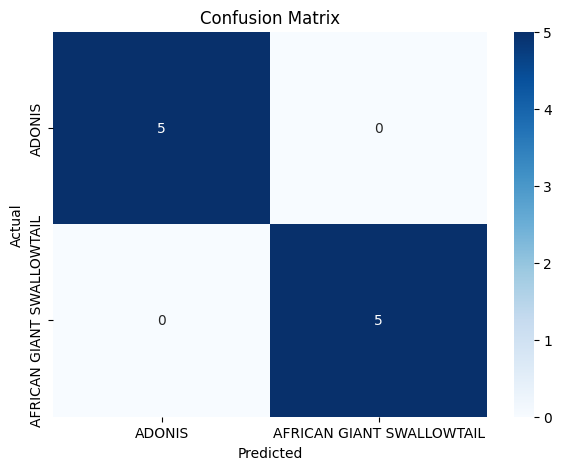

Fully supervised results: Accuracy 1.0, Precision 1.0, Recall 1.0, F1-score 1.0


In [11]:
# Redo the new SVM but using the best kernel and gamma
psuedo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(train_data_bn, train_labels_bn)
predictions = psuedo_classifier.predict(test_data_bn)

cm = confusion_matrix(test_labels_bn, predictions)                # Calculate the confusion matrix

plt.figure(figsize=(7,5))                                        # Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Determine the new estimation parameter 
accuracy = round(accuracy_score(test_labels_bn, predictions), 4)
precision = round(precision_score(test_labels_bn, predictions, average='macro'), 4)
recall = round(recall_score(test_labels_bn, predictions, average='macro'), 4)
f1 = f1_score(test_labels_bn, predictions, average='macro')
print(f'Fully supervised results: Accuracy {accuracy}, Precision {precision}, Recall {recall}, F1-score {f1}')

final_results = []
final_results.append({'Pipeline': 'BW-SVM', 'Kernel' : best_kernel, 'Gamma' : best_gamma, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})

#### KNN

In [12]:
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(train_data_bn.shape[0]))]       # Use the odd values and the root of the shape
weights = ['uniform', 'distance']                                              # The wights and metrics used
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']

results = []                                                                   # The results array

for n, w, m in product(n_neighbors, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)             # Create the K-NN classifier with the current hyperparameters

    knn.fit(train_data_bn, train_labels_bn)                                    # Fit the model to the training data

    predictions = knn.predict(test_data_bn)                                     # Make predictions on the test data


    # Calulate accuracy, precision, recall and f1 values
    accuracy = round(accuracy_score(test_labels_bn, predictions), 4)
    precision = round(precision_score(test_labels_bn, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(test_labels_bn, predictions, average='macro'), 4)
    f1 = f1_score(test_labels_bn, predictions, average='macro')

    results.append({'n_neighbors' : n, 'weights' : w, 'metric' : m, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})
    

knn_df = pd.DataFrame(results)                                                 # Create a dataframe with results
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)

print(knn_df)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
0             3   uniform  euclidean       1.0     1.0000     1.0  1.000000
27            7  distance     cosine       1.0     1.0000     1.0  1.000000
1             3   uniform  manhattan       1.0     1.0000     1.0  1.000000
31            9   uniform  manhattan       1.0     1.0000     1.0  1.000000
32            9   uniform     cosine       1.0     1.0000     1.0  1.000000
34            9   uniform  minkowski       1.0     1.0000     1.0  1.000000
35            9  distance  euclidean       1.0     1.0000     1.0  1.000000
36            9  distance  manhattan       1.0     1.0000     1.0  1.000000
37            9  distance     cosine       1.0     1.0000     1.0  1.000000
39            9  distance  minkowski       1.0     1.0000     1.0  1.000000
40           11   uniform  euclidean       1.0     1.0000     1.0  1.000000
41           11   uniform  manhattan       1.0     1.0000     1.0  1.000000
42          

In [13]:
best_row_index = knn_df['Accuracy'].idxmax()                           # Look for the row in the DataFrame that has the highest accuracy

best_n_neighbors = knn_df.loc[best_row_index, 'n_neighbors']           # Search the best neighbors, weights and metric
best_weights = knn_df.loc[best_row_index, 'weights']
best_metric = knn_df.loc[best_row_index, 'metric']

print("\nBest n_neighbors, weights and metric:",best_n_neighbors, best_weights, best_metric)


Best n_neighbors, weights and metric: 3 uniform euclidean


#### Confusion Matrix for KNN

Accuracy: 1.0


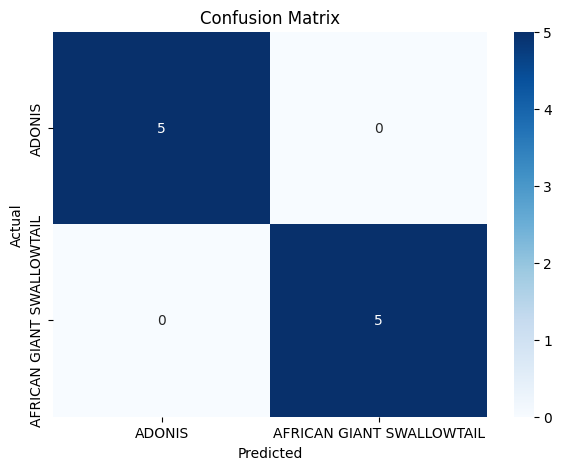

In [14]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric) # With the best parameters create a new model
knn.fit(train_data_bn, train_labels_bn)
y_pred = knn.predict(test_data_bn)

accuracy = accuracy_score(test_labels_bn, y_pred)                                                  # Calculate the accuracy
print(f'Accuracy: {accuracy}')

cm = confusion_matrix(test_labels_bn, y_pred)                                                      # Determinate the confusion matrix

plt.figure(figsize=(7,5))                                                                          # Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Store the performance results of the KNN model 
final_results.append({'Pipeline': 'BW-KNN', 'n_neighbors' : best_n_neighbors, 'weights' : best_weights, 'metric' : best_metric, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})


## Models of SVM and KNN (using PCA) for images in black/white

#### PCA Variance threshold

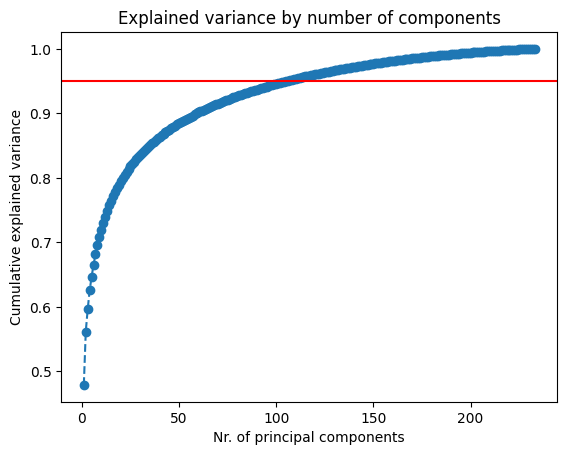

In [15]:
scaler = MinMaxScaler()                                     # Scale (normalize) the data
scaled_train_data = scaler.fit_transform(train_data_bn)     # Tranform the data in a np_array

RAND_STATE = 0                                              # Apply PCA without specifying the number of components to keep
pca = PCA(random_state = RAND_STATE)
pca.fit(scaled_train_data)

# Plot the variance ratio in a cumulative fashion, to visualize the cumulative variance plot
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle='--')
plt.axhline(y=0.95, color = 'r', linestyle = '-')
plt.title('Explained variance by number of components')
plt.ylabel('Cumulative explained variance')
plt.xlabel('Nr. of principal components')
plt.show()

In [16]:
n_comp = np.where(pca.explained_variance_ratio_.cumsum() > 0.95)[0][0]     # Visualize the number of the component, when i go over the 95%
print('The numer of component is ', n_comp)

The numer of component is  105


Perform PCA on train data and test data:

We use the required component numbers to explain that more than 95% of the variance is used to create a new PCA object and perform final reduced dimensionalities on the data

In [17]:
pca = PCA(n_components=n_comp, random_state=RAND_STATE)      # Apply the pca
pca_train_data = pca.fit_transform(scaled_train_data)

scaled_test_data = scaler.fit_transform(test_data_bn)
pca_test_data = pca.transform(scaled_test_data)

#### SVM (using PCA) Black and white

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
0   linear  scale       1.0     1.0000     1.0   1.00000
1   linear   auto       1.0     1.0000     1.0   1.00000
2     poly  scale       1.0     1.0000     1.0   1.00000
3     poly   auto       1.0     1.0000     1.0   1.00000
5      rbf   auto       1.0     1.0000     1.0   1.00000
6  sigmoid  scale       1.0     1.0000     1.0   1.00000
7  sigmoid   auto       1.0     1.0000     1.0   1.00000
4      rbf  scale       0.9     0.9167     0.9   0.89899

Best kernel and gamma:  linear scale


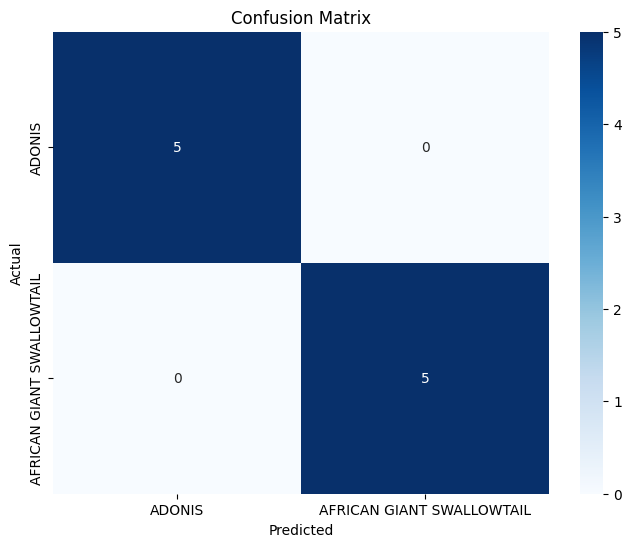

In [41]:
# Repeat svm again but with the data obtained from the pca
kernels = ["linear", "poly", "rbf", "sigmoid"]
gammas = ["scale", "auto"]
results = []

for kernel in kernels:
    for gamma in gammas:
        pseudo_classifier = OneVsRestClassifier(SVC(kernel=kernel, degree=1, C=1, gamma=gamma, probability=True)).fit(pca_train_data, train_labels_bn)
        
        predictions = pseudo_classifier.predict(pca_test_data)

        acc = round(accuracy_score(test_labels_bn, predictions), 4)
        precision = round(precision_score(test_labels_bn, predictions, average='macro', zero_division=1), 4)
        recall = round(recall_score(test_labels_bn, predictions, average='macro', zero_division=1), 4)
        f1 = f1_score(test_labels_bn, predictions, average='macro', zero_division=1)

        results.append({'Kernel': kernel, 'Gamma': gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

svm_df = pd.DataFrame(results)
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)  
print(svm_df)

best_row_index = svm_df['Accuracy'].idxmax()
best_kernel = svm_df.loc[best_row_index, 'Kernel']
best_gamma = svm_df.loc[best_row_index, 'Gamma']
print("\nBest kernel and gamma: ", best_kernel, best_gamma)

pseudo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(pca_train_data, train_labels_bn)
predictions = pseudo_classifier.predict(pca_test_data)

cm = confusion_matrix(test_labels_bn, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

acc = round(accuracy_score(test_labels_bn, predictions), 4)
precision = round(precision_score(test_labels_bn, predictions, average='macro'), 4)
recall = round(recall_score(test_labels_bn, predictions, average='macro'), 4)
f1 = f1_score(test_labels_bn, predictions, average='macro')

result={'Kernel': best_kernel, 'Gamma': best_gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

result['Pipeline'] = 'BW-PCA-SVM'       
final_results.append(result)

#### K-NN (using PCA) Black/White

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
0             3   uniform  euclidean       1.0     1.0000     1.0  1.000000
46           11  distance  manhattan       1.0     1.0000     1.0  1.000000
32            9   uniform     cosine       1.0     1.0000     1.0  1.000000
33            9   uniform  chebyshev       1.0     1.0000     1.0  1.000000
36            9  distance  manhattan       1.0     1.0000     1.0  1.000000
37            9  distance     cosine       1.0     1.0000     1.0  1.000000
38            9  distance  chebyshev       1.0     1.0000     1.0  1.000000
40           11   uniform  euclidean       1.0     1.0000     1.0  1.000000
41           11   uniform  manhattan       1.0     1.0000     1.0  1.000000
42           11   uniform     cosine       1.0     1.0000     1.0  1.000000
43           11   uniform  chebyshev       1.0     1.0000     1.0  1.000000
44           11   uniform  minkowski       1.0     1.0000     1.0  1.000000
45          

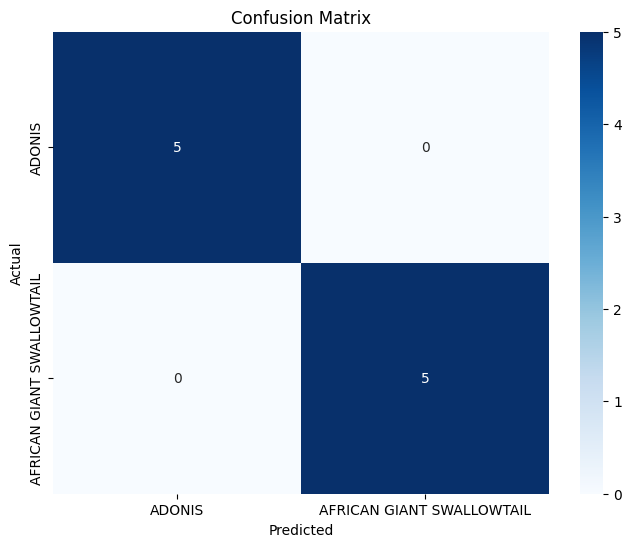

In [19]:
# Repeat knn again but with the data obtained from the pca
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(pca_train_data.shape[0]))]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']
results = []

for n, w, m in product(n_neighbors, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)
    knn.fit(pca_train_data, train_labels_bn)
    
    predictions = knn.predict(pca_test_data)
    accuracy = accuracy_score(test_labels_bn, predictions)
    
    acc = round(accuracy_score(test_labels_bn, predictions), 4)
    precision = round(precision_score(test_labels_bn, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(test_labels_bn, predictions, average='macro'), 4)    
    f1 = f1_score(test_labels_bn, predictions, average='macro')

    results.append({'n_neighbors': n, 'weights': w, 'metric' : m, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

knn_df = pd.DataFrame(results)
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(knn_df)  

best_row_index = knn_df['Accuracy'].idxmax()
best_n_neighbors = knn_df.loc[best_row_index, 'n_neighbors']
best_weights = knn_df.loc[best_row_index, 'weights']
best_metric = knn_df.loc[best_row_index, 'metric']
print(best_n_neighbors, best_weights, best_metric)

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)
knn.fit(pca_train_data, train_labels_bn)
y_pred = knn.predict(pca_test_data)

accuracy = accuracy_score(test_labels_bn, y_pred)
print("Accuracy:", accuracy)
precision = round(precision_score(test_labels_bn, predictions, average='macro', zero_division=1), 4)
recall = round(recall_score(test_labels_bn, predictions, average='macro'), 4)
f1 = f1_score(test_labels_bn, predictions, average='macro')

cm = confusion_matrix(test_labels_bn, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
result ={'n_neighbors': best_n_neighbors, 'weights': best_weights, 'metric' : best_metric, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

result['Pipeline'] = 'BW-PCA-KNN'
final_results.append(result)

In [20]:
# Create a table with the best performance of the models with their parameters
res_df = pd.DataFrame(final_results)                                                         
res_df.sort_values(by='Pipeline', key=lambda x: x.str[-1], ascending=False, inplace=True)

res_df

,Pipeline,Kernel,Gamma,Accuracy,Precision,Recall,F1-score,n_neighbors,weights,metric
1,BW-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
3,BW-PCA-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
0,BW-SVM,linear,scale,1.0,1.0,1.0,1.0,NaN,NaN,NaN
2,BW-PCA-SVM,poly,scale,1.0,1.0,1.0,1.0,NaN,NaN,NaN


## Models of SVM and KNN (without using PCA) for colored images

In [21]:
# Print some information about our images
print(f'Number of images: {len(images)}')
images_np = np.array(images)

print('Shape of images: ', images_np.shape)                                  

images_np_res = images_np.reshape((len(images)), -1)
print('Reshape of images: ', images_np_res.shape)

Number of images: 253
Shape of images:  (253, 50, 50, 3)
Reshape of images:  (253, 7500)


#### SVM (without PCA)

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
0   linear  scale       1.0     1.0000     1.0  1.000000
1   linear   auto       1.0     1.0000     1.0  1.000000
2     poly  scale       1.0     1.0000     1.0  1.000000
3     poly   auto       1.0     1.0000     1.0  1.000000
4      rbf  scale       1.0     1.0000     1.0  1.000000
5      rbf   auto       0.5     0.7500     0.5  0.333333
7  sigmoid   auto       0.5     0.7500     0.5  0.333333
6  sigmoid  scale       0.4     0.2222     0.4  0.285714

Best kernel and gamma:  linear scale


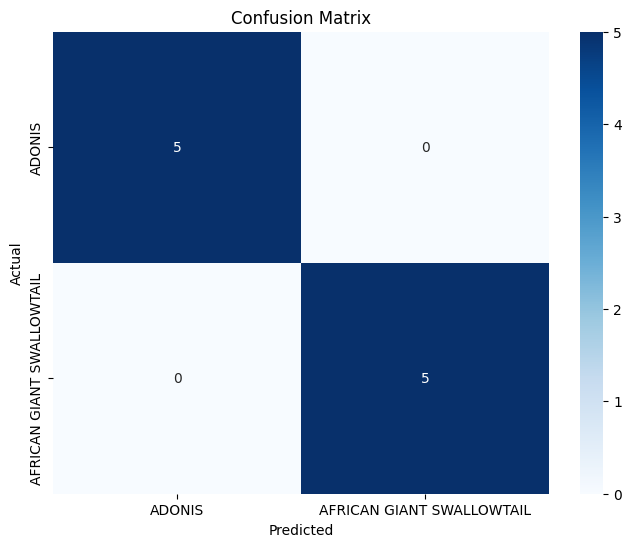

In [22]:
# Repeat svm again but with the data obtained from the pca
kernels = ["linear", "poly", "rbf", "sigmoid"]
gammas = ["scale", "auto"]
results = []

for kernel in kernels:
    for gamma in gammas:
        pseudo_classifier = OneVsRestClassifier(SVC(kernel=kernel, degree=1, C=1, gamma=gamma, probability=True)).fit(train_data_colored, train_labels_colored)
        
        predictions = pseudo_classifier.predict(test_data_colored)

        acc = round(accuracy_score(test_labels_colored, predictions), 4)
        precision = round(precision_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
        recall = round(recall_score(test_labels_colored, predictions, average='macro'), 4)
        f1 = f1_score(test_labels_colored, predictions, average='macro')

        results.append({'Kernel': kernel, 'Gamma': gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

svm_df = pd.DataFrame(results)
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)  
print(svm_df)

best_row_index = svm_df['Accuracy'].idxmax()
best_kernel = svm_df.loc[best_row_index, 'Kernel']
best_gamma = svm_df.loc[best_row_index, 'Gamma']
print("\nBest kernel and gamma: ", best_kernel, best_gamma)

pseudo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(train_data_colored, train_labels_colored)
predictions = pseudo_classifier.predict(test_data_colored)

cm = confusion_matrix(test_labels_colored, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

acc = round(accuracy_score(test_labels_colored, predictions), 4)
precision = round(precision_score(test_labels_colored, predictions, average='macro'), 4)
recall = round(recall_score(test_labels_colored, predictions, average='macro'), 4)
f1 = f1_score(test_labels_colored, predictions, average='macro')

result={'Kernel': best_kernel, 'Gamma': best_gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

result["Pipeline"]="RGB-SVM"
final_results.append(result)

#### KNN (without PCA)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
0             3   uniform  euclidean       1.0     1.0000     1.0  1.000000
1             3   uniform  manhattan       1.0     1.0000     1.0  1.000000
32            9   uniform     cosine       1.0     1.0000     1.0  1.000000
33            9   uniform  chebyshev       1.0     1.0000     1.0  1.000000
34            9   uniform  minkowski       1.0     1.0000     1.0  1.000000
35            9  distance  euclidean       1.0     1.0000     1.0  1.000000
36            9  distance  manhattan       1.0     1.0000     1.0  1.000000
37            9  distance     cosine       1.0     1.0000     1.0  1.000000
38            9  distance  chebyshev       1.0     1.0000     1.0  1.000000
39            9  distance  minkowski       1.0     1.0000     1.0  1.000000
40           11   uniform  euclidean       1.0     1.0000     1.0  1.000000
41           11   uniform  manhattan       1.0     1.0000     1.0  1.000000
42          

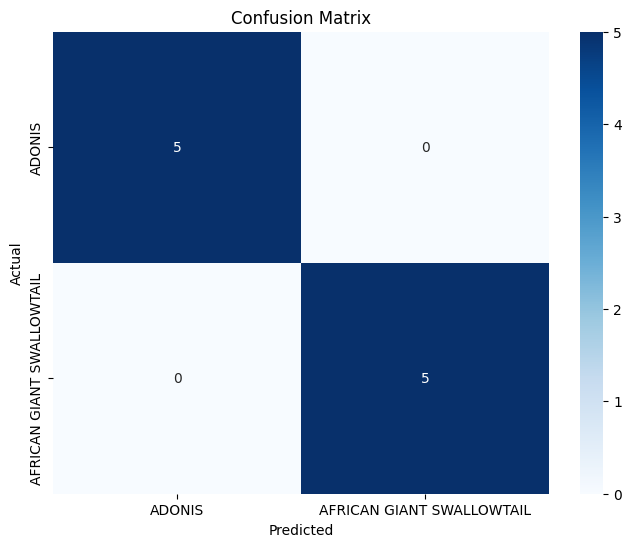

In [23]:
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(train_data_colored.shape[0]))]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']
results = []

for n, w, m in product(n_neighbors, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)
    knn.fit(train_data_colored, train_labels_colored)
    
    predictions = knn.predict(test_data_colored)
    accuracy = accuracy_score(test_labels_colored, predictions)
    
    acc = round(accuracy_score(test_labels_colored, predictions), 4)
    precision = round(precision_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(test_labels_colored, predictions, average='macro'), 4)    
    f1 = f1_score(test_labels_colored, predictions, average='macro')

    results.append({'n_neighbors': n, 'weights': w, 'metric' : m, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

knn_df = pd.DataFrame(results)
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(knn_df)  

best_row_index = knn_df['Accuracy'].idxmax()
best_n_neighbors = knn_df.loc[best_row_index, 'n_neighbors']
best_weights = knn_df.loc[best_row_index, 'weights']
best_metric = knn_df.loc[best_row_index, 'metric']
print(best_n_neighbors, best_weights, best_metric)

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)
knn.fit(train_data_colored, train_labels_colored)
y_pred = knn.predict(test_data_colored)

accuracy = accuracy_score(test_labels_colored, y_pred)
print("Accuracy:", accuracy)
precision = round(precision_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
recall = round(recall_score(test_labels_colored, predictions, average='macro'), 4)
f1 = f1_score(test_labels_colored, predictions, average='macro')

cm = confusion_matrix(test_labels_colored, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

result={'n_neighbors': best_n_neighbors, 'weights': best_weights, 'metric' : best_metric, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

result["Pipeline"]="RGB-KNN"
final_results.append(result)

## Models of SVM and KNN (using PCA) for colored images

#### PCA Variance threshold

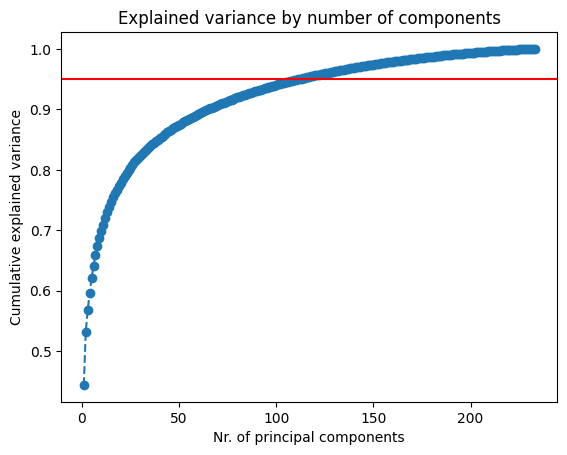

111


In [24]:
scaler = MinMaxScaler()                                                   # Normalize the data
scaled_train_data = scaler.fit_transform(train_data_colored)

pca = PCA(random_state=RAND_STATE)                                        # Apply PCA
pca.fit(scaled_train_data)

# Plot the results from the pca
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.axhline(y=0.95, color = 'r', linestyle='-')
plt.title('Explained variance by number of components')
plt.ylabel('Cumulative explained variance')
plt.xlabel('Nr. of principal components')
plt.show()

# Determine the number of principal components needed to explain at least 95 percent of the variance in the data 
n_comp = np.where(pca.explained_variance_ratio_.cumsum() > 0.95)[0][0]         
print(n_comp)

Use the number of components needed to explain more than 80% of the variance in order to create a new PCA object and perform the final dimensionality reduction on the data

In [25]:
pca = PCA(n_components=n_comp, random_state=RAND_STATE)        # Create a pca object 
pca_train_data = pca.fit_transform(scaled_train_data)          # Normalize the data

scaled_test_data = scaler.fit_transform(test_data_colored)
pca_test_data = pca.transform(scaled_test_data)                # Apply pca to the normalize data

#### SVM (with PCA)

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
0   linear  scale       1.0     1.0000     1.0   1.00000
1   linear   auto       1.0     1.0000     1.0   1.00000
2     poly  scale       1.0     1.0000     1.0   1.00000
3     poly   auto       1.0     1.0000     1.0   1.00000
4      rbf  scale       1.0     1.0000     1.0   1.00000
6  sigmoid  scale       1.0     1.0000     1.0   1.00000
7  sigmoid   auto       1.0     1.0000     1.0   1.00000
5      rbf   auto       0.9     0.9167     0.9   0.89899

Best kernel and gamma:  linear scale


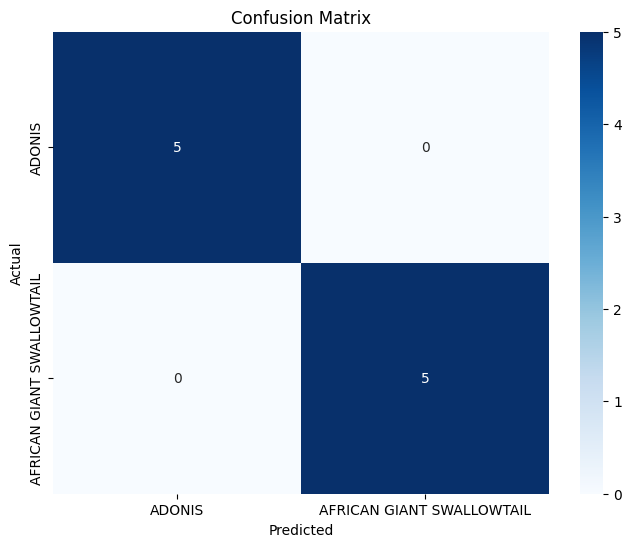

In [26]:
# Repeat svm again but with the data obtained from the pca
kernels = ["linear", "poly", "rbf", "sigmoid"]
gammas = ["scale", "auto"]
results = []

for kernel in kernels:
    for gamma in gammas:
        pseudo_classifier = OneVsRestClassifier(SVC(kernel=kernel, degree=1, C=1, gamma=gamma, probability=True)).fit(pca_train_data, train_labels_colored)
        
        predictions = pseudo_classifier.predict(pca_test_data)

        acc = round(accuracy_score(test_labels_colored, predictions), 4)
        precision = round(precision_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
        recall = round(recall_score(test_labels_colored, predictions, average='macro'), 4)
        f1 = f1_score(test_labels_colored, predictions, average='macro')

        results.append({'Kernel': kernel, 'Gamma': gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

svm_df = pd.DataFrame(results)
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)  
print(svm_df)

best_row_index = svm_df['Accuracy'].idxmax()
best_kernel = svm_df.loc[best_row_index, 'Kernel']
best_gamma = svm_df.loc[best_row_index, 'Gamma']
print("\nBest kernel and gamma: ", best_kernel, best_gamma)

pseudo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(pca_train_data, train_labels_colored)
predictions = pseudo_classifier.predict(pca_test_data)

cm = confusion_matrix(test_labels_colored, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

acc = round(accuracy_score(test_labels_colored, predictions), 4)
precision = round(precision_score(test_labels_colored, predictions, average='macro'), 4)
recall = round(recall_score(test_labels_colored, predictions, average='macro'), 4)
f1 = f1_score(test_labels_colored, predictions, average='macro')

result={'Kernel': best_kernel, 'Gamma': best_gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1}


result["Pipeline"]="RGB-PCA-SVM"
final_results.append(result)

#### KNN (with PCA)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
0             3   uniform  euclidean       1.0        1.0     1.0       1.0
1             3   uniform  manhattan       1.0        1.0     1.0       1.0
32            9   uniform     cosine       1.0        1.0     1.0       1.0
33            9   uniform  chebyshev       1.0        1.0     1.0       1.0
34            9   uniform  minkowski       1.0        1.0     1.0       1.0
35            9  distance  euclidean       1.0        1.0     1.0       1.0
36            9  distance  manhattan       1.0        1.0     1.0       1.0
37            9  distance     cosine       1.0        1.0     1.0       1.0
38            9  distance  chebyshev       1.0        1.0     1.0       1.0
39            9  distance  minkowski       1.0        1.0     1.0       1.0
40           11   uniform  euclidean       1.0        1.0     1.0       1.0
41           11   uniform  manhattan       1.0        1.0     1.0       1.0
42          

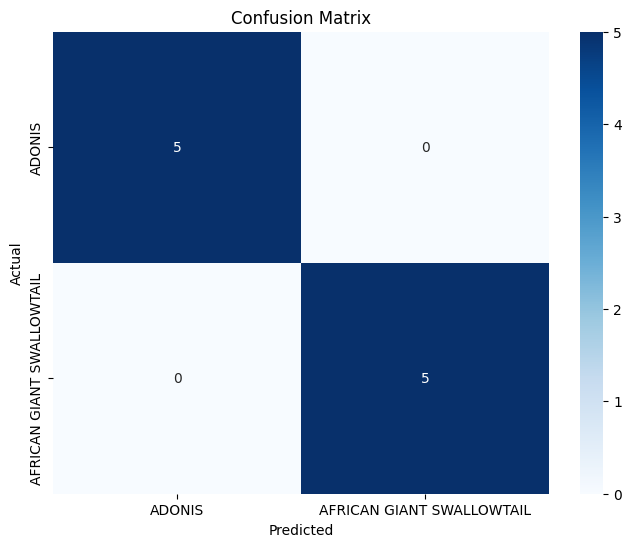

In [27]:
# Repeat knn again but with the data obtained from the pca
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(pca_train_data.shape[0]))]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']
results = []

for n, w, m in product(n_neighbors, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)
    knn.fit(pca_train_data, train_labels_colored)
    
    predictions = knn.predict(pca_test_data)
    accuracy = accuracy_score(test_labels_colored, predictions)
    
    acc = round(accuracy_score(test_labels_colored, predictions), 4)
    precision = round(precision_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(test_labels_colored, predictions, average='macro'), 4)    
    f1 = f1_score(test_labels_colored, predictions, average='macro')

    results.append({'n_neighbors': n, 'weights': w, 'metric' : m, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

knn_df = pd.DataFrame(results)
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(knn_df)  

best_row_index = knn_df['Accuracy'].idxmax()
best_n_neighbors = knn_df.loc[best_row_index, 'n_neighbors']
best_weights = knn_df.loc[best_row_index, 'weights']
best_metric = knn_df.loc[best_row_index, 'metric']
print(best_n_neighbors, best_weights, best_metric)

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)
knn.fit(pca_train_data, train_labels_colored)
y_pred = knn.predict(pca_test_data)

accuracy = accuracy_score(test_labels_colored, y_pred)
print("Accuracy:", accuracy)
precision = round(precision_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
recall = round(recall_score(test_labels_colored, predictions, average='macro'), 4)
f1 = f1_score(test_labels_colored, predictions, average='macro')

cm = confusion_matrix(test_labels_colored, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
result ={'n_neighbors': best_n_neighbors, 'weights': best_weights, 'metric' : best_metric, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

result["Pipeline"]="RGB-PCA-KNN"
final_results.append(result)

#### Comparing results

In [28]:
res_df = pd.DataFrame(final_results)                                                          # Create DataFrame from final results
res_df.sort_values(by='Pipeline', key=lambda x: x.str[-1], ascending=False, inplace=True)     # Sort by last character in Pipeline column descending
res_df                                                                                        # Show the sorted DataFrame

,Pipeline,Kernel,Gamma,Accuracy,Precision,Recall,F1-score,n_neighbors,weights,metric
1,BW-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
3,BW-PCA-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
5,RGB-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
7,RGB-PCA-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
0,BW-SVM,linear,scale,1.0,1.0,1.0,1.0,NaN,NaN,NaN
2,BW-PCA-SVM,poly,scale,1.0,1.0,1.0,1.0,NaN,NaN,NaN
4,RGB-SVM,linear,scale,1.0,1.0,1.0,1.0,NaN,NaN,NaN
6,RGB-PCA-SVM,linear,scale,1.0,1.0,1.0,1.0,NaN,NaN,NaN


## Models of SVM and KNN (without using PCA) for HSV images

#### SVM

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
2     poly  scale       1.0     1.0000     1.0  1.000000
4      rbf  scale       1.0     1.0000     1.0  1.000000
6  sigmoid  scale       1.0     1.0000     1.0  1.000000
0   linear  scale       0.9     0.9167     0.9  0.898990
1   linear   auto       0.9     0.9167     0.9  0.898990
3     poly   auto       0.9     0.9167     0.9  0.898990
5      rbf   auto       0.5     0.7500     0.5  0.333333
7  sigmoid   auto       0.5     0.7500     0.5  0.333333

Best kernel and gamma:  poly scale


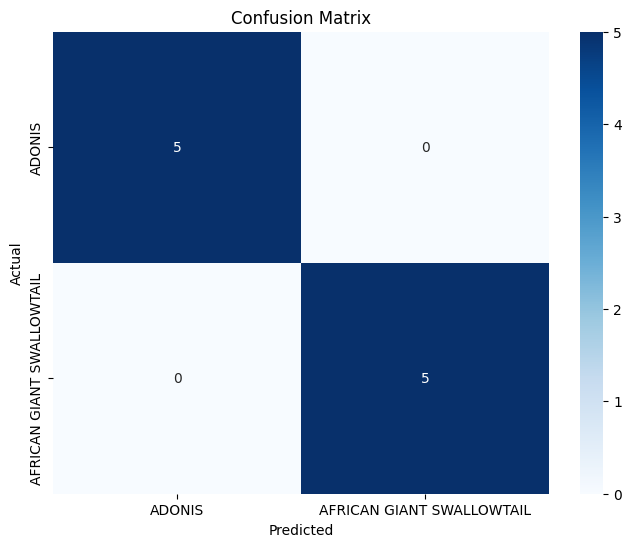

In [29]:
# SVM is applied on HSV data
kernels = ["linear", "poly", "rbf", "sigmoid"]
gammas = ["scale", "auto"]
results = []

for kernel in kernels:
    for gamma in gammas:
        pseudo_classifier = OneVsRestClassifier(SVC(kernel=kernel, degree=1, C=1, gamma=gamma, probability=True)).fit(train_data_hsv, train_labels_hsv)
        
        predictions = pseudo_classifier.predict(test_data_hsv)

        acc = round(accuracy_score(test_labels_hsv, predictions), 4)
        precision = round(precision_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
        recall = round(recall_score(test_labels_hsv, predictions, average='macro'), 4)
        f1 = f1_score(test_labels_hsv, predictions, average='macro')

        results.append({'Kernel': kernel, 'Gamma': gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

svm_df = pd.DataFrame(results)
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)  
print(svm_df)

best_row_index = svm_df['Accuracy'].idxmax()
best_kernel = svm_df.loc[best_row_index, 'Kernel']
best_gamma = svm_df.loc[best_row_index, 'Gamma']
print("\nBest kernel and gamma: ", best_kernel, best_gamma)

pseudo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(train_data_hsv, train_labels_hsv)
predictions = pseudo_classifier.predict(test_data_hsv)

cm = confusion_matrix(test_labels_hsv, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

acc = round(accuracy_score(test_labels_hsv, predictions), 4)
precision = round(precision_score(test_labels_hsv, predictions, average='macro'), 4)
recall = round(recall_score(test_labels_hsv, predictions, average='macro'), 4)
f1 = f1_score(test_labels_hsv, predictions, average='macro')

result={'Kernel': best_kernel, 'Gamma': best_gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1}


result["Pipeline"]="HSV-SVM"
final_results.append(result)

#### KNN

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
0             3   uniform  euclidean       1.0     1.0000     1.0   1.00000
45           11  distance  euclidean       1.0     1.0000     1.0   1.00000
31            9   uniform  manhattan       1.0     1.0000     1.0   1.00000
32            9   uniform     cosine       1.0     1.0000     1.0   1.00000
34            9   uniform  minkowski       1.0     1.0000     1.0   1.00000
35            9  distance  euclidean       1.0     1.0000     1.0   1.00000
36            9  distance  manhattan       1.0     1.0000     1.0   1.00000
37            9  distance     cosine       1.0     1.0000     1.0   1.00000
39            9  distance  minkowski       1.0     1.0000     1.0   1.00000
40           11   uniform  euclidean       1.0     1.0000     1.0   1.00000
41           11   uniform  manhattan       1.0     1.0000     1.0   1.00000
42           11   uniform     cosine       1.0     1.0000     1.0   1.00000
44          

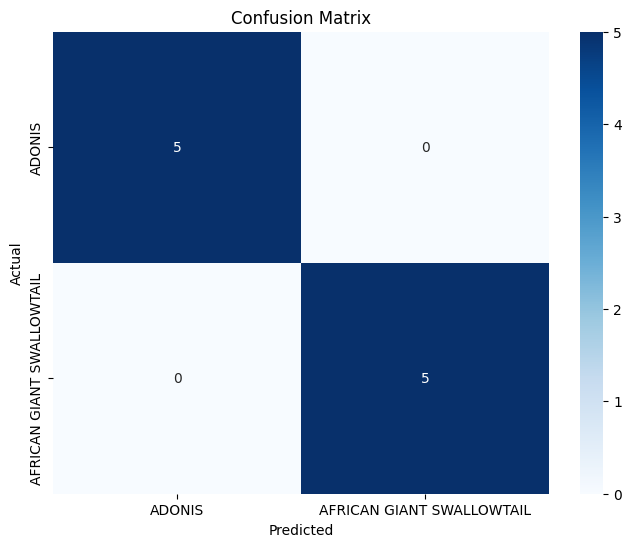

In [30]:
# KNN is applied on HSV data
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(train_data_hsv.shape[0]))]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']
results = []

for n, w, m in product(n_neighbors, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)
    knn.fit(train_data_hsv, train_labels_hsv)
    
    predictions = knn.predict(test_data_hsv)
    accuracy = accuracy_score(test_labels_hsv, predictions)
    
    acc = round(accuracy_score(test_labels_hsv, predictions), 4)
    precision = round(precision_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(test_labels_hsv, predictions, average='macro'), 4)    
    f1 = f1_score(test_labels_hsv, predictions, average='macro')

    results.append({'n_neighbors': n, 'weights': w, 'metric' : m, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

knn_df = pd.DataFrame(results)
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(knn_df)  

best_row_index = knn_df['Accuracy'].idxmax()
best_n_neighbors = knn_df.loc[best_row_index, 'n_neighbors']
best_weights = knn_df.loc[best_row_index, 'weights']
best_metric = knn_df.loc[best_row_index, 'metric']
print(best_n_neighbors, best_weights, best_metric)

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)
knn.fit(train_data_hsv, train_labels_hsv)
y_pred = knn.predict(test_data_hsv)

accuracy = accuracy_score(test_labels_hsv, y_pred)
print("Accuracy:", accuracy)
precision = round(precision_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
recall = round(recall_score(test_labels_hsv, predictions, average='macro'), 4)
f1 = f1_score(test_labels_hsv, predictions, average='macro')

cm = confusion_matrix(test_labels_hsv, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
result ={'n_neighbors': best_n_neighbors, 'weights': best_weights, 'metric' : best_metric, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

result["Pipeline"]="HSV-KNN"
final_results.append(result)

## Models of SVM and KNN (using PCA) for HSV images

#### PCA Variance threshold

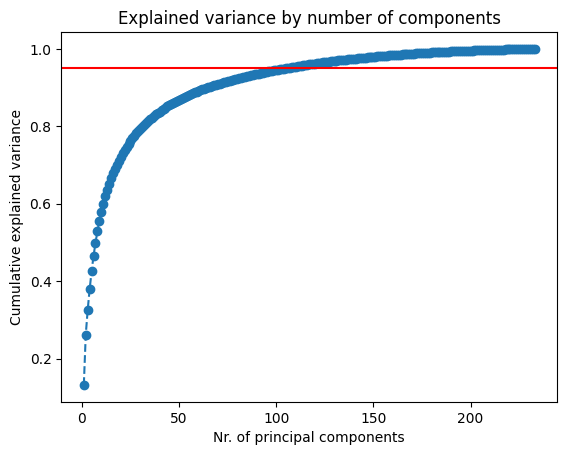

104


In [31]:
# Scale (Normalize) the data.
scaler = MinMaxScaler()                   # x-min / max-min
scaled_train_data = scaler.fit_transform(train_data_hsv)  # Data here become a np array, it's no longer a dataframe.

# Apply PCA without specifying the number of components to keep, in order to understand how many PCs are sufficient.
pca = PCA(random_state=RAND_STATE)
pca.fit(scaled_train_data)

# Plot the explained variance ratio in a cumulative fashion, in order to visualize the cumulative variance plot.
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.axhline(y=0.95, color = 'r', linestyle='-')
plt.title('Explained variance by number of components')
plt.ylabel('Cumulative explained variance')
plt.xlabel('Nr. of principal components')
plt.show()

n_comp = np.where(pca.explained_variance_ratio_.cumsum() > 0.95)[0][0]
print(n_comp)

# Use the number of components needed to explain more than 80% of the variance in order to create a new PCA object and
# perform the final dimensionality reduction on the data.
pca = PCA(n_components=n_comp, random_state=RAND_STATE)
pca_train_data = pca.fit_transform(scaled_train_data)

scaled_test_data = scaler.fit_transform(test_data_hsv)
pca_test_data = pca.transform(scaled_test_data)

#### SVM (with PCA)

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
0   linear  scale       1.0     1.0000     1.0   1.00000
1   linear   auto       1.0     1.0000     1.0   1.00000
2     poly  scale       1.0     1.0000     1.0   1.00000
3     poly   auto       1.0     1.0000     1.0   1.00000
5      rbf   auto       1.0     1.0000     1.0   1.00000
6  sigmoid  scale       1.0     1.0000     1.0   1.00000
7  sigmoid   auto       1.0     1.0000     1.0   1.00000
4      rbf  scale       0.9     0.9167     0.9   0.89899

Best kernel and gamma:  linear scale


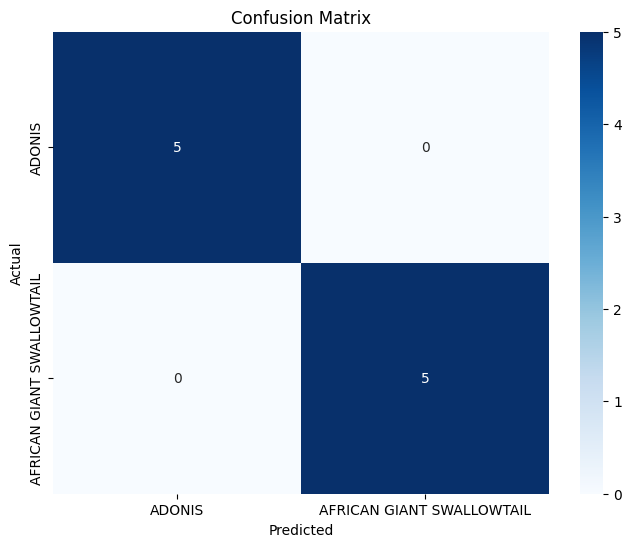

In [32]:
# SVM is applied on HSV data with PCA
kernels = ["linear", "poly", "rbf", "sigmoid"]
gammas = ["scale", "auto"]
results = []

for kernel in kernels:
    for gamma in gammas:
        pseudo_classifier = OneVsRestClassifier(SVC(kernel=kernel, degree=1, C=1, gamma=gamma, probability=True)).fit(pca_train_data, train_labels_hsv)
        
        predictions = pseudo_classifier.predict(pca_test_data)

        acc = round(accuracy_score(test_labels_hsv, predictions), 4)
        precision = round(precision_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
        recall = round(recall_score(test_labels_hsv, predictions, average='macro'), 4)
        f1 = f1_score(test_labels_hsv, predictions, average='macro')

        results.append({'Kernel': kernel, 'Gamma': gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

svm_df = pd.DataFrame(results)
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)  
print(svm_df)

best_row_index = svm_df['Accuracy'].idxmax()
best_kernel = svm_df.loc[best_row_index, 'Kernel']
best_gamma = svm_df.loc[best_row_index, 'Gamma']
print("\nBest kernel and gamma: ", best_kernel, best_gamma)

pseudo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(pca_train_data, train_labels_hsv)
predictions = pseudo_classifier.predict(pca_test_data)

cm = confusion_matrix(test_labels_hsv, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

acc = round(accuracy_score(test_labels_hsv, predictions), 4)
precision = round(precision_score(test_labels_hsv, predictions, average='macro'), 4)
recall = round(recall_score(test_labels_hsv, predictions, average='macro'), 4)
f1 = f1_score(test_labels_hsv, predictions, average='macro')

result={'Kernel': best_kernel, 'Gamma': best_gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1}


result["Pipeline"]="HSV-PCA-SVM"
final_results.append(result)

#### KNN (with PCA)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
59           15  distance  minkowski       1.0     1.0000     1.0  1.000000
40           11   uniform  euclidean       1.0     1.0000     1.0  1.000000
42           11   uniform     cosine       1.0     1.0000     1.0  1.000000
31            9   uniform  manhattan       1.0     1.0000     1.0  1.000000
32            9   uniform     cosine       1.0     1.0000     1.0  1.000000
21            7   uniform  manhattan       1.0     1.0000     1.0  1.000000
41           11   uniform  manhattan       1.0     1.0000     1.0  1.000000
18            5  distance  chebyshev       1.0     1.0000     1.0  1.000000
44           11   uniform  minkowski       1.0     1.0000     1.0  1.000000
45           11  distance  euclidean       1.0     1.0000     1.0  1.000000
46           11  distance  manhattan       1.0     1.0000     1.0  1.000000
47           11  distance     cosine       1.0     1.0000     1.0  1.000000
13          

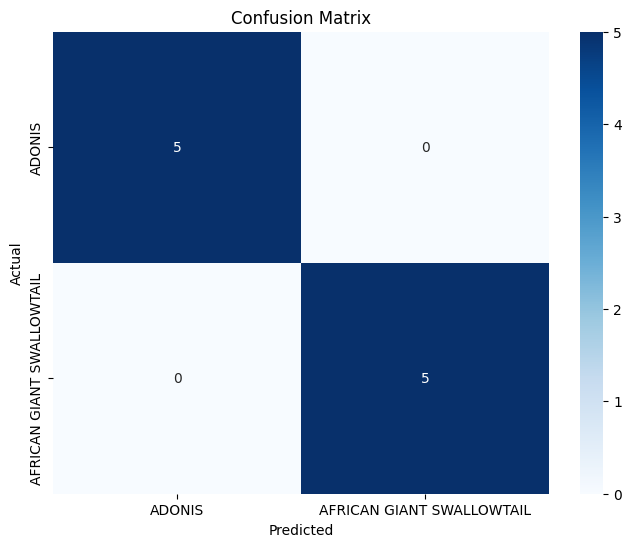

In [33]:
# KNN is applied on HSV data with PCA
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(pca_train_data.shape[0]))]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']
results = []

for n, w, m in product(n_neighbors, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)
    knn.fit(pca_train_data, train_labels_hsv)
    
    predictions = knn.predict(pca_test_data)
    accuracy = accuracy_score(test_labels_hsv, predictions)
    
    acc = round(accuracy_score(test_labels_hsv, predictions), 4)
    precision = round(precision_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(test_labels_hsv, predictions, average='macro'), 4)    
    f1 = f1_score(test_labels_hsv, predictions, average='macro')

    results.append({'n_neighbors': n, 'weights': w, 'metric' : m, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

knn_df = pd.DataFrame(results)
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(knn_df)  

best_row_index = knn_df['Accuracy'].idxmax()
best_n_neighbors = knn_df.loc[best_row_index, 'n_neighbors']
best_weights = knn_df.loc[best_row_index, 'weights']
best_metric = knn_df.loc[best_row_index, 'metric']
print(best_n_neighbors, best_weights, best_metric)

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)
knn.fit(pca_train_data, train_labels_hsv)
y_pred = knn.predict(pca_test_data)

accuracy = accuracy_score(test_labels_hsv, y_pred)
print("Accuracy:", accuracy)
precision = round(precision_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
recall = round(recall_score(test_labels_hsv, predictions, average='macro'), 4)
f1 = f1_score(test_labels_hsv, predictions, average='macro')

cm = confusion_matrix(test_labels_hsv, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
result ={'n_neighbors': best_n_neighbors, 'weights': best_weights, 'metric' : best_metric, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

result["Pipeline"]="HSV-PCA-KNN"
final_results.append(result)

#### Comparing results

In [34]:
res_df = pd.DataFrame(final_results)                                                          # Create DataFrame from final results
res_df.sort_values(by='Pipeline', key=lambda x: x.str[-1], ascending=False, inplace=True)     # Sort by last character in Pipeline column descending
res_df                                                                                        # Show the sorted DataFrame

,Pipeline,Kernel,Gamma,Accuracy,Precision,Recall,F1-score,n_neighbors,weights,metric
1,BW-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
3,BW-PCA-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
5,RGB-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
7,RGB-PCA-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
9,HSV-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
11,HSV-PCA-KNN,NaN,NaN,1.0,1.0,1.0,1.0,15.0,distance,minkowski
0,BW-SVM,linear,scale,1.0,1.0,1.0,1.0,NaN,NaN,NaN
2,BW-PCA-SVM,poly,scale,1.0,1.0,1.0,1.0,NaN,NaN,NaN
4,RGB-SVM,linear,scale,1.0,1.0,1.0,1.0,NaN,NaN,NaN
6,RGB-PCA-SVM,linear,scale,1.0,1.0,1.0,1.0,NaN,NaN,NaN


## VGG Extractor Feature

In [35]:
normalization_std = [0.229, 0.224, 0.225]
normalization_mean = [0.485, 0.456, 0.406]

loader  = transforms.Compose([transforms.ToTensor(),
                              transforms.RandomResizedCrop(224),
                              transforms.Normalize(mean=normalization_mean,
                                                   std=normalization_std)])


# Initialing compute device (use GPU if available).
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

vgg_dict_x = {
    'train': [],
    'test': [],
    'valid': []
}
vgg_dict_y = {
    'train': [],
    'test': [],
    'valid': []
}

# Initialize the model.
model = models.vgg16(weights=VGG16_Weights.DEFAULT).features.to(device)
model.eval()  # Set the model to evaluation mode


for i, row in df_new.iterrows():
    filepath = row['filepaths']
    class_id = row['class id']
    index = row['data set']

    image = Image.open(filepath).convert('RGB')
    # Fake batch dimension required to fit network's input dimensions.
    image = loader(image).unsqueeze(0).to(device)

    # Extract features
    with torch.no_grad():
        features = model(image).squeeze().cpu().numpy()
        features_flattened = features.flatten()  # Flatten the features
        vgg_dict_x[index].append(features_flattened)  # Append the flattened features
        vgg_dict_y[index].append(class_id)  # Append the class_id

# Convert lists to numpy arrays
features_train = np.array(vgg_dict_x['train'])
features_test = np.array(vgg_dict_x['test'])
labels_train = np.array(vgg_dict_y['train'])
labels_test = np.array(vgg_dict_y['test'])

print(features_train.shape)
print(features_test.shape)

(233, 25088)
(10, 25088)


#### SVM

In [36]:
kernels = ["linear", "poly", "rbf", "sigmoid"]                 # Types of kernel
gammas = ["scale", "auto"]                                     # Types of gamma

results = []                                                   # Array that memorize the results

for kn in kernels:                                             # for each kernel
    for gm in gammas:                                          # for each gamma
        # Create a classifier with OneVsRest approach
        psuedo_classifier = OneVsRestClassifier(SVC(kernel=kn, degree=1, C=1, gamma=gm, probability=True)).fit(features_train, labels_train)
        
        predizione = psuedo_classifier.predict(features_test)   # Prediction on test data using the trained model

        accuracy = round(accuracy_score(labels_test, predizione), 4)                                         # Make the accuracy study
        precision = round(precision_score(labels_test, predizione, average='macro', zero_division=1), 4)     # Make the precision study
        recall = round(recall_score(labels_test, predizione, average='macro'), 4)                            # Make the recall study
        f1 = f1_score(labels_test, predizione, average='macro')                                              # Make the f1 study

        # Stores SVM model performance results
        results.append({'Kernel' : kn, 'Gamma' : gm, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})

svm_df = pd.DataFrame(results)                                         # Create a dataframe with results
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)       # Reorder by accuracy the results

print(svm_df)                                                          # Show the svm results


best_row_index = svm_df['Accuracy'].idxmax()                           # Memorize the Kernel with Better Range
best_kernel = svm_df.loc[best_row_index, 'Kernel']                    
best_gamma = svm_df.loc[best_row_index, 'Gamma']

print("\nBest kernel and gamma: ", best_kernel, best_gamma)

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
0   linear  scale       1.0        1.0     1.0       1.0
1   linear   auto       1.0        1.0     1.0       1.0
2     poly  scale       1.0        1.0     1.0       1.0
3     poly   auto       1.0        1.0     1.0       1.0
4      rbf  scale       1.0        1.0     1.0       1.0
5      rbf   auto       1.0        1.0     1.0       1.0
6  sigmoid  scale       1.0        1.0     1.0       1.0
7  sigmoid   auto       1.0        1.0     1.0       1.0

Best kernel and gamma:  linear scale


#### Confusion Matrix 

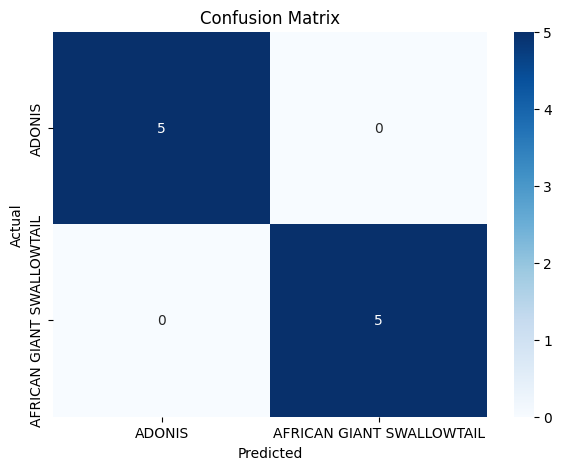

Fully supervised results: Accuracy 1.0, Precision 1.0, Recall 1.0, F1-score 1.0


In [37]:
# Redo the new SVM but using the best kernel and gamma
psuedo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(features_train, labels_train)
predictions = psuedo_classifier.predict(features_test)

cm = confusion_matrix(labels_test, predictions)                # Calculate the confusion matrix

plt.figure(figsize=(7,5))                                        # Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Determine the new estimation parameter 
accuracy = round(accuracy_score(labels_test, predictions), 4)
precision = round(precision_score(labels_test, predictions, average='macro'), 4)
recall = round(recall_score(labels_test, predictions, average='macro'), 4)
f1 = f1_score(labels_test, predictions, average='macro')
print(f'Fully supervised results: Accuracy {accuracy}, Precision {precision}, Recall {recall}, F1-score {f1}')

final_results.append({'Pipeline': 'VGG-SVM', 'Kernel' : best_kernel, 'Gamma' : best_gamma, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})

#### KNN

In [38]:
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(features_train.shape[0]))]       # Use the odd values and the root of the shape
weights = ['uniform', 'distance']                                              # The wights and metrics used
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']

results = []                                                                   # The results array

for n, w, m in product(n_neighbors, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)             # Create the K-NN classifier with the current hyperparameters

    knn.fit(features_train, labels_train)                                    # Fit the model to the training data

    predictions = knn.predict(features_test)                                     # Make predictions on the test data


    # Calulate accuracy, precision, recall and f1 values
    accuracy = round(accuracy_score(labels_test, predictions), 4)
    precision = round(precision_score(labels_test, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(labels_test, predictions, average='macro'), 4)
    f1 = f1_score(labels_test, predictions, average='macro')

    results.append({'n_neighbors' : n, 'weights' : w, 'metric' : m, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})
    

knn_df = pd.DataFrame(results)                                                 # Create a dataframe with results
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)

print(knn_df)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
0             3   uniform  euclidean       1.0     1.0000     1.0  1.000000
26            7  distance  manhattan       1.0     1.0000     1.0  1.000000
29            7  distance  minkowski       1.0     1.0000     1.0  1.000000
31            9   uniform  manhattan       1.0     1.0000     1.0  1.000000
32            9   uniform     cosine       1.0     1.0000     1.0  1.000000
34            9   uniform  minkowski       1.0     1.0000     1.0  1.000000
35            9  distance  euclidean       1.0     1.0000     1.0  1.000000
36            9  distance  manhattan       1.0     1.0000     1.0  1.000000
37            9  distance     cosine       1.0     1.0000     1.0  1.000000
39            9  distance  minkowski       1.0     1.0000     1.0  1.000000
40           11   uniform  euclidean       1.0     1.0000     1.0  1.000000
41           11   uniform  manhattan       1.0     1.0000     1.0  1.000000
42          

#### Confusion Matrix

Accuracy: 1.0


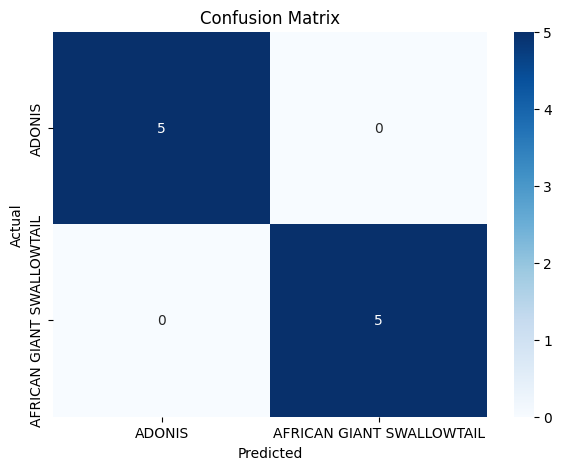

In [39]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric) # With the best parameters create a new model
knn.fit(features_train, labels_train)
y_pred = knn.predict(features_test)

accuracy = accuracy_score(labels_test, y_pred)                                                  # Calculate the accuracy
print(f'Accuracy: {accuracy}')

cm = confusion_matrix(labels_test, y_pred)                                                      # Determinate the confusion matrix

plt.figure(figsize=(7,5))                                                                          # Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Store the performance results of the KNN model 
final_results.append({'Pipeline': 'VGG-KNN', 'n_neighbors' : best_n_neighbors, 'weights' : best_weights, 'metric' : best_metric, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})


#### Comparing results

In [40]:
res_df = pd.DataFrame(final_results)                                                          # Create DataFrame from final results
res_df.sort_values(by='Pipeline', key=lambda x: x.str[-1], ascending=False, inplace=True)     # Sort by last character in Pipeline column descending
res_df                                                                                        # Show the sorted DataFrame

,Pipeline,Kernel,Gamma,Accuracy,Precision,Recall,F1-score,n_neighbors,weights,metric
1,BW-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
3,BW-PCA-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
5,RGB-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
7,RGB-PCA-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
9,HSV-KNN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,uniform,euclidean
11,HSV-PCA-KNN,NaN,NaN,1.0,1.0,1.0,1.0,15.0,distance,minkowski
13,VGG-KNN,NaN,NaN,1.0,1.0,1.0,1.0,15.0,distance,minkowski
0,BW-SVM,linear,scale,1.0,1.0,1.0,1.0,NaN,NaN,NaN
2,BW-PCA-SVM,poly,scale,1.0,1.0,1.0,1.0,NaN,NaN,NaN
4,RGB-SVM,linear,scale,1.0,1.0,1.0,1.0,NaN,NaN,NaN
